In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from category_encoders.cat_boost import CatBoostEncoder
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, average_precision_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, ClusterMixin


In [2]:
df_NAFill = pd.read_csv('Dataset_after_filling_NA.csv').iloc[:, 1:]

In [3]:
def target_encoding(df, target_column):
    df_encoded = df.copy()
    for col in df.columns[df.dtypes == 'object']:
        if col != target_column:
            mapping = df.groupby(col)[target_column].mean()
            df_encoded[col] = df_encoded[col].map(mapping)
    return df_encoded

df_target = target_encoding(df_NAFill, 'isFraud')

In [4]:
new_categorical = df_NAFill.columns[df_NAFill.dtypes == 'object']
catboost_encoder = CatBoostEncoder()
encode = catboost_encoder.fit_transform(df_NAFill[new_categorical], df_NAFill['isFraud'])
df_cat = df_NAFill.copy()
df_cat[new_categorical] = encode

In [5]:
df_onehot = pd.get_dummies(df_NAFill, columns=df_NAFill.columns[df_NAFill.dtypes == 'object'], dummy_na=False)

In [6]:
def X_y_train_test(df):
    X = df.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']), axis=1)
    y = list(df.sort_values('TransactionDT')['isFraud'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.fit_transform(X_test)
    return (X_scaled_train, X_scaled_test, y_train, y_test)

In [31]:
def show_performance(y_test, y_pred):
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1-score:", f1)    
    print("MCC:", matthews_corrcoef(y_test, y_pred))

    print('')
    
    precision_l, recall_l, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_l, precision_l)

    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
    print("AUC-PR:", pr_auc)


In [38]:
def visual_performance(y_test, y_pred, y_pred_proba):   
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', lw=2)
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate (FPR)')
    axes[0].set_ylabel('True Positive Rate (TPR)')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)

    axes[1].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})', lw=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
def draw_3d_plot(score_df, parameter_col, target_col):
    grouped_df = score_df.groupby(parameter_col, as_index=False)[target_col].mean()
    X = grouped_df[parameter_col[0]]
    Y = grouped_df[parameter_col[1]]
    Z = grouped_df[parameter_col[2]]
    T = grouped_df[target_col]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X, Y, Z, c=T, cmap='viridis', s=100)
    ax.set_xlabel(parameter_col[0].replace('sgd__', ''))
    ax.set_ylabel(parameter_col[1].replace('sgd__', ''))
    ax.set_zlabel(parameter_col[2].replace('sgd__', ''))
    ax.set_title('3D Plot of Mean Test Score')
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Mean Test Score', rotation=270, labelpad=15)
    plt.show()

In [9]:
X_train, X_test, y_train, y_test = X_y_train_test(df_onehot)

In [10]:
IF = IsolationForest(n_estimators=200, contamination=0.08,max_features=0.9, max_samples=0.59, n_jobs=-1, random_state=42).fit(X_train)

In [13]:
y_pred_proba = IF.decision_function(X_test)
y_pred_proba = (y_pred_proba- np.min(y_pred_proba))/(np.max(y_pred_proba)-np.min(y_pred_proba))
y_pred_proba = 1 - y_pred_proba

y_pred = IF.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)

In [32]:
show_performance(y_test, y_pred)

Recall: 0.21706454465075153
Accuracy: 0.865150622248414
Precision: 0.18812260536398467
F1-score: 0.201559934318555
MCC: 0.12871852969200873

AUC-ROC: 0.5686789715918794
AUC-PR: 0.23329000791200288


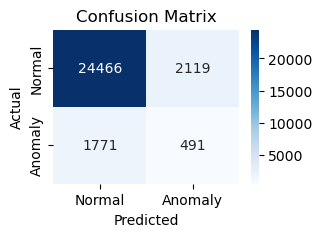

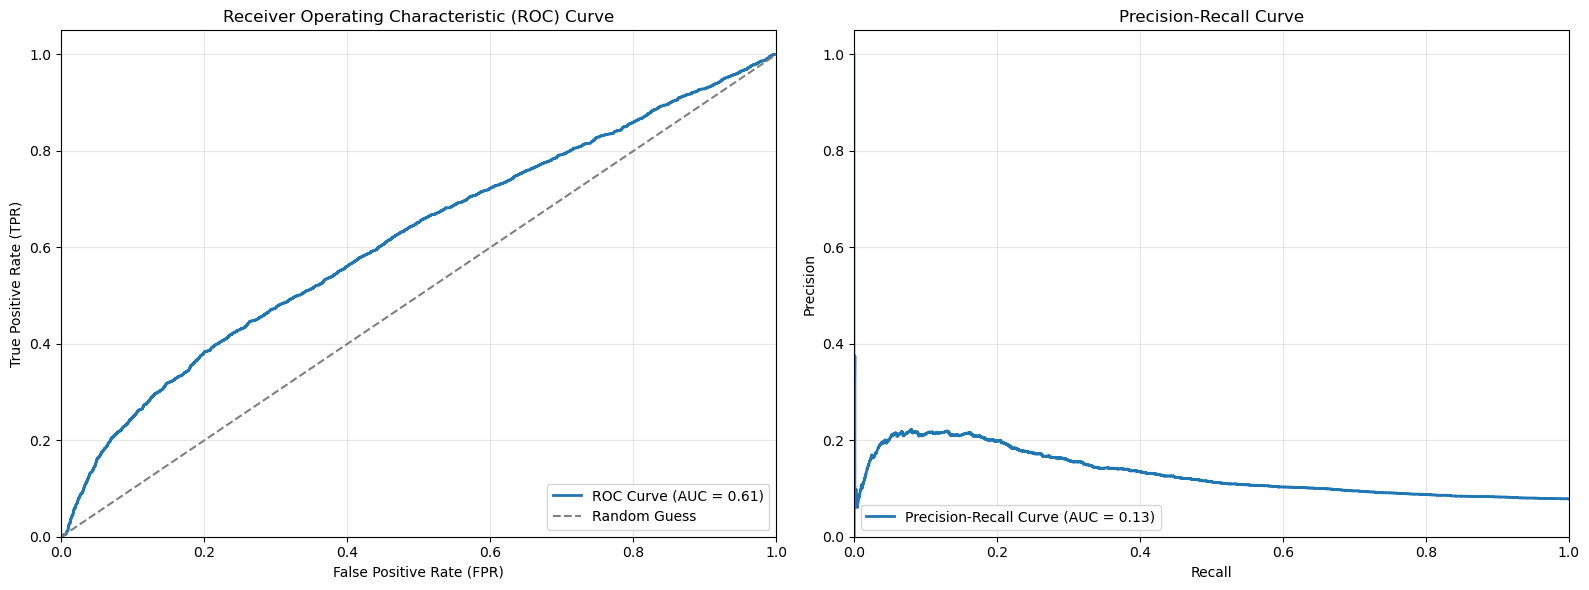

In [39]:
visual_performance(y_test, y_pred, y_pred_proba)

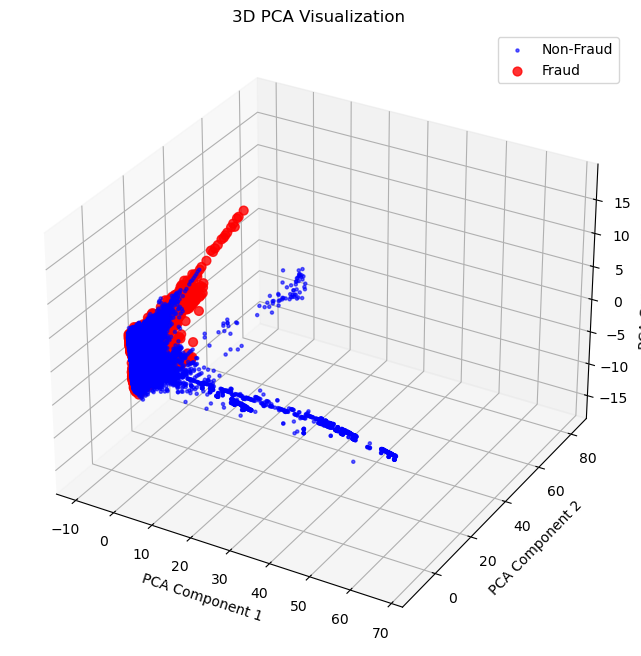

In [40]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

pca_df = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2', 'PCA_3'])
pca_df['Label'] = y_train

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

fraud = pca_df[pca_df['Label'] == 1]
non_fraud = pca_df[pca_df['Label'] == 0]

ax.scatter(non_fraud['PCA_1'], non_fraud['PCA_2'], non_fraud['PCA_3'],
           c='blue', label='Non-Fraud', alpha=0.6, s=5)

ax.scatter(fraud['PCA_1'], fraud['PCA_2'], fraud['PCA_3'],
           c='red', label='Fraud', alpha=0.8, s=40)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization')
ax.legend()

plt.show()